# Building embeddings from our corpus

Now we have our corpus, we can build our embeddings.

There are different types of embeddings. At our corpus we will work with word embeddings. However we could think of sentence embeddings, paragraph embeddings, document embeddings, even character or subword embeddings.

Word embeddings are vector representations of words. They are useful for many NLP tasks, such as sentiment analysis, text classification, and machine translation. They are also useful for visualising the relationships between words. For example, we can use them to find words with similar meanings, or to find words that are often used together.

## Why do we need embeddings?

Computers and most machine learnign algorithms in particular work better with numerical data. However, words are not numbers. So we need to find a way to represent words as numbers.

Large Language Models such as ChatGPT also use word embeddings to represent words. However, they are trained on huge amounts of data, and so are not always suitable for smaller projects. In this notebook, we will build our own word embeddings from our corpus.

## Different types of embedddings

There are different types of word embeddings as well, such as:

- Word2Vec
- GloVe
- FastText
- BERT

 We will  also use the gensim library to do this. Gensim is a library for topic modelling, document indexing and similarity retrieval with large corpora. It uses the word2vec algorithm to create vector representations of words, which can then be used to find words with similar meanings.

In [2]:
# We will be using the same dataset as in the previous notebook
# usual standard imports
from pathlib import Path
from datetime import datetime

#python version
import sys
print("Python ver:", sys.version)


import pandas as pd
# print version
print("Pandas ver:", pd.__version__)

# we will need gensim for word2vec embeddings
import gensim
# print version
print("Gensim ver:", gensim.__version__)

# we will need scikit learn for tfidf embeddings
import sklearn
# print version
print("Scikit learn ver:", sklearn.__version__)

Python ver: 3.11.4 (tags/v3.11.4:d2340ef, Jun  7 2023, 05:45:37) [MSC v.1934 64 bit (AMD64)]
Pandas ver: 2.0.3
Gensim ver: 4.3.1
Scikit learn ver: 1.3.0


In [3]:
# now let's load parquet file directly from url
url = "https://github.com/ValRCS/BSSDH_2023_workshop/raw/main/data/old_bailey_sample_1720_1913_cleaned.parquet"
df = pd.read_parquet(url)
print("Dataframe shape:", df.shape)

Dataframe shape: (1637, 9)


In [4]:
# how much memory does this dataframe use?
print("Dataframe size:", df.memory_usage(deep=True).sum())
# supposedly Pandas 2.0 has better memory management for strings


Dataframe size: 5686694


In [5]:
# let's get some statistics about our dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1637 entries, 1720 to 1913
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   trial_number        1637 non-null   int64 
 1   punishment          1162 non-null   object
 2   text                1637 non-null   object
 3   dirty_len           1637 non-null   int64 
 4   clean_len           1637 non-null   int64 
 5   words               1637 non-null   object
 6   word_count          1637 non-null   int64 
 7   word_count_cleaned  1637 non-null   int64 
 8   words_lemmatized    1637 non-null   object
dtypes: int64(5), object(4)
memory usage: 127.9+ KB


In [6]:
# we can get basic statistics about our dataframe
df.describe() # for numerical columns - returns a dataframe as well

,trial_number,dirty_len,clean_len,word_count,word_count_cleaned
count,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000
mean,49.329872,3227.827734,3091.967013,608.543677,257.531460
std,34.327506,7288.101079,7020.877032,1376.101195,544.264694
min,1.000000,57.000000,51.000000,10.000000,6.000000
25%,22.000000,302.000000,285.000000,50.000000,31.000000
50%,44.000000,1359.000000,1291.000000,245.000000,115.000000
75%,70.000000,3453.000000,3299.000000,654.000000,277.000000
max,173.000000,161044.000000,156144.000000,29928.000000,11270.000000


<Axes: >

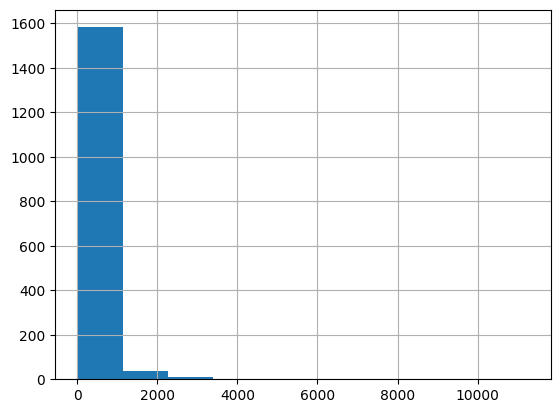

In [7]:
# we might want to plot histogram of word_count_cleaned
# this will give us a more detailed view of the distribution of word counts
df.word_count_cleaned.hist() # this will plot histogram of word counts 

In [8]:
# looks like we have some outliers, let's see what they are
df[df.word_count_cleaned > 10000]
# looks like there was a very long trial that ended up badly for the defendant

,trial_number,punishment,text,dirty_len,clean_len,words,word_count,word_count_cleaned,words_lemmatized
year,,,,,,,,,
1872,1,DEATH,117 john selby watson 67 was indicted for the ...,161044,156144,"[117, john, selby, watson, 67, indicted, wilfu...",29928,11270,"[117, john, selby, watson, 67, indict, wilful,..."


<Axes: >

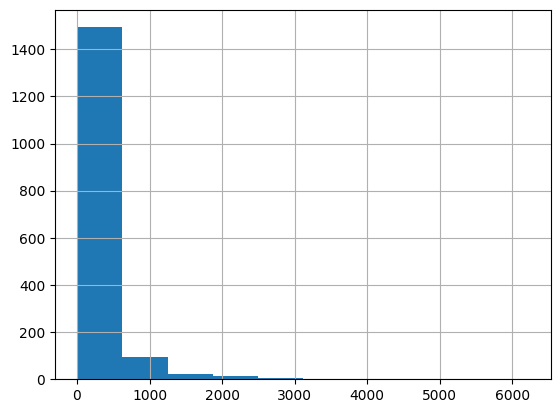

In [9]:
# for our histogram we will skip this outlier
df[df.word_count_cleaned < 10000].word_count_cleaned.hist()

<Axes: >

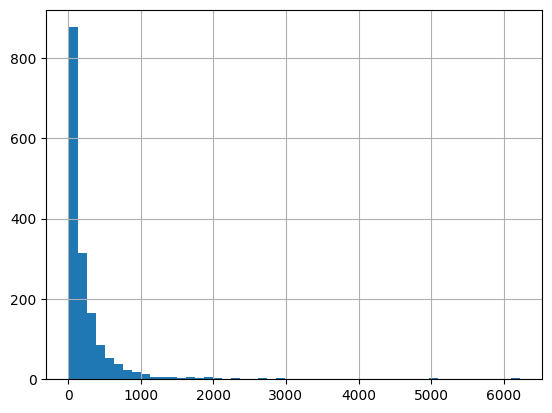

In [10]:
# we are still not getting a good view of the distribution
# let's increase the number of bins
df[df.word_count_cleaned < 10000].word_count_cleaned.hist(bins=50)


<Axes: >

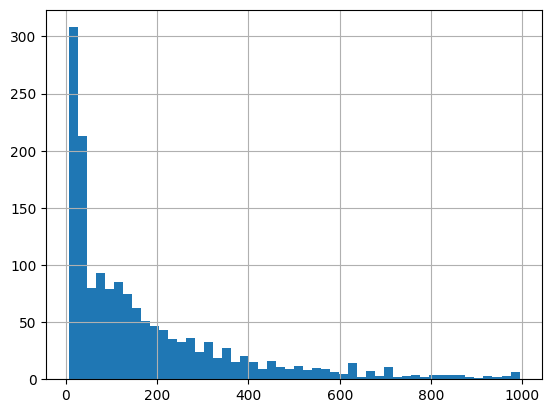

In [11]:
# again we can see that most of the documents are short
# certainly Justice in England was swift and brutal

# let's see distribution among shorter documents of less than 1000 words
df[df.word_count_cleaned < 1000].word_count_cleaned.hist(bins=50)

## Concerns on short texts

Short texts might not have enough information to build good embeddings. However, we will try to build them anyway.

In [ ]:
# I am concerned that we will not get very useful embeddings from the very short documents but for now we will leave them in